In [1]:
#!/usr/bin/python3
#!/usr/bin/env python3
# coding: utf-8

import os
import re
import pymysql
import requests
import datetime
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
from bs4 import BeautifulSoup
from pymysql.converters import escape_string
from logging.handlers import RotatingFileHandler

In [2]:
# Set up logging
# Create a txt file in the new file under the path of the current .py file to save logs
log_path = "/Users/liangbaoyan/Desktop/trade_operation_mini_project/logs/"
file_name = log_path + "std.log" 

# Check if current path exists, if not then create new folder
if not os.path.exists(log_path):  
    os.makedirs(log_path)
    file = open(file_name, 'w')
    file.write("")
    file.close()

# Initialising the logging file configuration
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s\t%(module)s\t%(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    filename=file_name,
                    filemode='w')

console = logging.StreamHandler()
logger = logging.getLogger("a")
logger.setLevel(logging.DEBUG)

# Configuration for exporting logs to files
fh = RotatingFileHandler(file_name, maxBytes=200000, backupCount=7, encoding="utf-8")
fh.setLevel(logging.INFO)
fomatter = logging.Formatter('%(asctime)s\t%(module)s\t%(message)s', '%Y-%m-%d %H:%M:%S')
fh.setFormatter(fomatter)

# Add file write handler
logger.addHandler(fh)
# Add console stdout handler
logger.addHandler(console)

# Set up a mini database to load movie data from imdb website
def runSql(sql):
    # Change environment variables to connect MySQL database
    db = pymysql.connect(host="127.0.0.1",
                         port=3306,
                         user="root",
                         password="baoyan19920419",
                         db="trade_operation_mini_project",
                         charset="utf8")

    cursor = db.cursor()
    try:
        cursor.execute(sql)

        results = cursor.fetchall()
        db.commit()
        cursor.close()  # Close cursor
        db.close()
    except:
        print("error: ", sql)

    return results

In [3]:
# Scraping IMDB's Top 250 data

link = 'https://www.imdb.com/chart/top/'

# Getting response from the link
url = requests.get(link)

soup = BeautifulSoup(url.content, 'html.parser')

# Getting the movies' infomration like name, year, rating, etc. and store the data into a list
list = []

movies = soup.find('tbody', class_="lister-list").find_all('tr')
for movie in movies:
   # Movie name and year
    movie_name = movie.find('td', class_="titleColumn").find('a').text
    year = movie.find('td', class_="titleColumn").find('span').text.replace(')', '').replace('(', '')
    
    # Get more details from movies' links
    new_link = 'https://www.imdb.com'+ movie.find('td', class_="titleColumn").a.get('href')
    new_url = requests.get(new_link)
    new_soup = BeautifulSoup(new_url.content, 'html.parser')

    # Movie id 
    rank_details = new_soup.find('div', class_="sc-fcdc3619-0 YgLMu base")
    movie_rank = rank_details.find('div', class_="sc-fcdc3619-1 buTRxb").find('a').text
    id = (''.join(re.findall("\d+",movie_rank)))
    
    # Rating and genres
    movie_details = new_soup.find('div', class_="sc-7643a8e3-10 itwFpV")
    rating = movie_details.find('div', class_="sc-7ab21ed2-0 fAePGh").span.text
    all_genres = movie_details.find('div', class_="ipc-chip-list__scroller").find_all('a')
    genre = []
    for i in all_genres:
        genre.append(i.span.text)
    genres = (', '.join(genre))
    
    # Popularity and metascore (some movies don't have these data)
    try:
        popularity = int((''.join(re.findall("\d+",movie_details.find('div', class_="sc-edc76a2-0 bZeUlh").div.text))))
    except AttributeError:
        popularity = 0
        
    try:
        metascore = int(movie_details.find('span', class_="score-meta").text)
    except AttributeError:
        metascore = 0
    
    # Director, writers and stars
    director = movie_details.ul.li.div.text
    writers = movie_details.ul.li.find_next_sibling().div.text
    
    all_stars = movie_details.ul.li.find_next_sibling().find_next_sibling().div.ul.find_all('a')
    star = []
    for x in all_stars:
        star.append(x.text)
    stars = (', '.join(star))
    
    # Gross worldwide and budget
    gross_worldwide = 0
    budget = 0
    box_details = new_soup.find('div', attrs={"data-testid": "title-boxoffice-section"})
    
    if box_details is not None:
        for box_detail in box_details:
            li_details = box_detail.find_all('li')
        
            for li_detail in li_details:
                res = li_detail.find('span')

                if res.text == "Gross worldwide" :
                    gross_content = li_detail.find('li').find('span')
                    gross_worldwide = (''.join(re.findall("\d+",gross_content.text)))

                if res.text == "Budget" :
                    budget_content = li_detail.find('li').find('span')
                    budget = (''.join(re.findall("\d+",budget_content.text)))
    
    # Storing data into a list                
    data = {
        "Id": int(id),
        "Name": movie_name,
        "Year": int(year),
        "Rating": float(rating),
        "Genres": genres,
        "Popularity": int(popularity),
        "Metascore": int(metascore),
        "Director": director,
        "Writers": writers,
        "Stars": stars,
        "Gross": int(gross_worldwide),
        "Budget": int(budget),
        "Link": new_link
        }
    list.append(data)

    logger.info(data)
    
   


{'Id': 1, 'Name': 'The Shawshank Redemption', 'Year': 1994, 'Rating': 9.3, 'Genres': 'Drama', 'Popularity': 82, 'Metascore': 81, 'Director': 'Frank Darabont', 'Writers': 'Stephen King(based on the short novel "Rita Hayworth and the Shawshank Redemption" by)Frank Darabont(screenplay by)', 'Stars': 'Tim Robbins, Morgan Freeman, Bob Gunton', 'Gross': 28884504, 'Budget': 25000000, 'Link': 'https://www.imdb.com/title/tt0111161/'}
{'Id': 2, 'Name': 'The Godfather', 'Year': 1972, 'Rating': 9.2, 'Genres': 'Crime, Drama', 'Popularity': 97, 'Metascore': 100, 'Director': 'Francis Ford Coppola', 'Writers': 'Mario Puzo(screenplay by)Francis Ford Coppola(screenplay by)', 'Stars': 'Marlon Brando, Al Pacino, James Caan', 'Gross': 250341816, 'Budget': 6000000, 'Link': 'https://www.imdb.com/title/tt0068646/'}
{'Id': 3, 'Name': 'The Dark Knight', 'Year': 2008, 'Rating': 9.0, 'Genres': 'Action, Crime, Drama', 'Popularity': 136, 'Metascore': 84, 'Director': 'Christopher Nolan', 'Writers': 'Jonathan Nolan(s

In [4]:
# Printing the details of mivies
for movie in list:
    print(movie['Id'], '-', movie['Name'], '-', movie['Year'],
            '-', movie['Rating'], '-', movie['Genres'], '-', movie['Popularity'],
            '-', movie['Metascore'], '-', movie['Director'], '-', movie['Writers'], 
            '-', movie['Stars'], '-', movie['Gross'], '-', movie['Budget'], '-', movie['Link'])
   

1 - The Shawshank Redemption - 1994 - 9.3 - Drama - 82 - 81 - Frank Darabont - Stephen King(based on the short novel "Rita Hayworth and the Shawshank Redemption" by)Frank Darabont(screenplay by) - Tim Robbins, Morgan Freeman, Bob Gunton - 28884504 - 25000000 - https://www.imdb.com/title/tt0111161/
2 - The Godfather - 1972 - 9.2 - Crime, Drama - 97 - 100 - Francis Ford Coppola - Mario Puzo(screenplay by)Francis Ford Coppola(screenplay by) - Marlon Brando, Al Pacino, James Caan - 250341816 - 6000000 - https://www.imdb.com/title/tt0068646/
3 - The Dark Knight - 2008 - 9.0 - Action, Crime, Drama - 136 - 84 - Christopher Nolan - Jonathan Nolan(screenplay)Christopher Nolan(screenplay)David S. Goyer(story) - Christian Bale, Heath Ledger, Aaron Eckhart - 1006234167 - 185000000 - https://www.imdb.com/title/tt0468569/
4 - The Godfather Part II - 1974 - 9.0 - Crime, Drama - 548 - 90 - Francis Ford Coppola - Francis Ford Coppola(screenplay by)Mario Puzo(screenplay by) - Al Pacino, Robert De Niro, 

In [5]:
# Traversing the list and storing it into MySQL database
for movie in list:
    sql = (
            "INSERT INTO Movies (Id, Name, Year, Rating, Genres, Popularity, Metascore, Director, Writers, Stars, Gross, Budget, Link) VALUES ('%d','%s','%d','%f','%s','%d','%d','%s','%s','%s','%d','%d','%s');") % (
            movie['Id'], 
            escape_string(movie['Name']), 
            movie['Year'],
            movie['Rating'], 
            movie['Genres'], 
            movie['Popularity'],
            movie['Metascore'], 
            escape_string(movie['Director']), 
            escape_string(movie['Writers']), 
            escape_string(movie['Stars']), 
            movie['Gross'],
            movie['Budget'],
            movie['Link']  
        )

    print(runSql(sql))
logger.debug(data)

()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()


{'Id': 250, 'Name': 'The Iron Giant', 'Year': 1999, 'Rating': 8.1, 'Genres': 'Animation, Action, Adventure', 'Popularity': 1922, 'Metascore': 85, 'Director': 'Brad Bird', 'Writers': 'Tim McCanlies(screenplay by)Brad Bird(screen story by)Ted Hughes(based on the book "The Iron Man" by)', 'Stars': 'Eli Marienthal, Harry Connick Jr., Jennifer Aniston', 'Gross': 23335817, 'Budget': 70000000, 'Link': 'https://www.imdb.com/title/tt0129167/'}


()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()


In [34]:
# Or storing the information into a csv file
movies = pd.DataFrame(list)
movies

movies.to_csv('/Users/liangbaoyan/Desktop/trade_operation_mini_project/imdb_top_250_movies.csv')
logger.info(movies.to_csv())  

,Id,Name,Year,Rating,Genres,Popularity,Metascore,Director,Writers,Stars,Gross,Budget,Link
0,1,The Shawshank Redemption,1994,9.3,Drama,82,81,Frank Darabont,"Stephen King(based on the short novel ""Rita Hayworth and the Shawshank Redemption"" by)Frank Darabont(screenplay by)","Tim Robbins, Morgan Freeman, Bob Gunton",28884504,25000000,https://www.imdb.com/title/tt0111161/
1,2,The Godfather,1972,9.2,"Crime, Drama",97,100,Francis Ford Coppola,Mario Puzo(screenplay by)Francis Ford Coppola(screenplay by),"Marlon Brando, Al Pacino, James Caan",250341816,6000000,https://www.imdb.com/title/tt0068646/
2,3,The Dark Knight,2008,9.0,"Action, Crime, Drama",136,84,Christopher Nolan,Jonathan Nolan(screenplay)Christopher Nolan(screenplay)David S. Goyer(story),"Christian Bale, Heath Ledger, Aaron Eckhart",1006234167,185000000,https://www.imdb.com/title/tt0468569/
3,4,The Godfather Part II,1974,9.0,"Crime, Drama",548,90,Francis Ford Coppola,Francis Ford Coppola(screenplay by)Mario Puzo(screenplay by),"Al

In [35]:
# Exploring data
movies.head()

,Id,Name,Year,Rating,Genres,Popularity,Metascore,Director,Writers,Stars,Gross,Budget,Link
0,1,The Shawshank Redemption,1994,9.3,Drama,82,81,Frank Darabont,"Stephen King(based on the short novel ""Rita Ha...","Tim Robbins, Morgan Freeman, Bob Gunton",28884504,25000000,https://www.imdb.com/title/tt0111161/
1,2,The Godfather,1972,9.2,"Crime, Drama",97,100,Francis Ford Coppola,Mario Puzo(screenplay by)Francis Ford Coppola(...,"Marlon Brando, Al Pacino, James Caan",250341816,6000000,https://www.imdb.com/title/tt0068646/
2,3,The Dark Knight,2008,9.0,"Action, Crime, Drama",136,84,Christopher Nolan,Jonathan Nolan(screenplay)Christopher Nolan(sc...,"Christian Bale, Heath Ledger, Aaron Eckhart",1006234167,185000000,https://www.imdb.com/title/tt0468569/
3,4,The Godfather Part II,1974,9.0,"Crime, Drama",548,90,Francis Ford Coppola,Francis Ford Coppola(screenplay by)Mario Puzo(...,"Al Pacino, Robert De Niro, Robert Duvall",47961919,13000000,https://www.imdb.com/title/tt0071562/
4,5,12 Angry Men,1957,9.0,"Crime, Drama",340,96,Sidney Lumet,"Reginald Rose(teleplay ""Twelve Angry Men"")","Henry Fonda, Lee J. Cobb, Martin Balsam",955,350000,https://www.imdb.com/title/tt0050083/


In [36]:
movies.describe()
logger.info(movies.describe())

               Id         Year      Rating   Popularity   Metascore  \
count  250.000000   250.000000  250.000000   250.000000  250.000000   
mean   125.500000  1986.488000    8.310000  1105.568000   75.472000   
std     72.312977    25.225287    0.228888  1154.080916   25.162309   
min      1.000000  1921.000000    8.000000     0.000000    0.000000   
25%     63.250000  1966.250000    8.100000   300.250000   71.250000   
50%    125.500000  1994.000000    8.200000   653.500000   82.500000   
75%    187.750000  2006.750000    8.400000  1530.500000   90.000000   
max    250.000000  2022.000000    9.300000  4944.000000  100.000000   

              Gross        Budget  
count  2.500000e+02  2.500000e+02  
mean   2.171546e+08  8.976695e+07  
std    3.643002e+08  6.515538e+08  
min    0.000000e+00  0.000000e+00  
25%    5.119206e+06  2.269750e+06  
50%    5.252765e+07  1.300000e+07  
75%    2.939744e+08  4.000000e+07  
max    2.797501e+09  1.000000e+10  


In [46]:
movies.columns

Index(['Id', 'Name', 'Year', 'Rating', 'Genres', 'Popularity', 'Metascore',
       'Director', 'Writers', 'Stars', 'Gross', 'Budget', 'Link'],
      dtype='object')

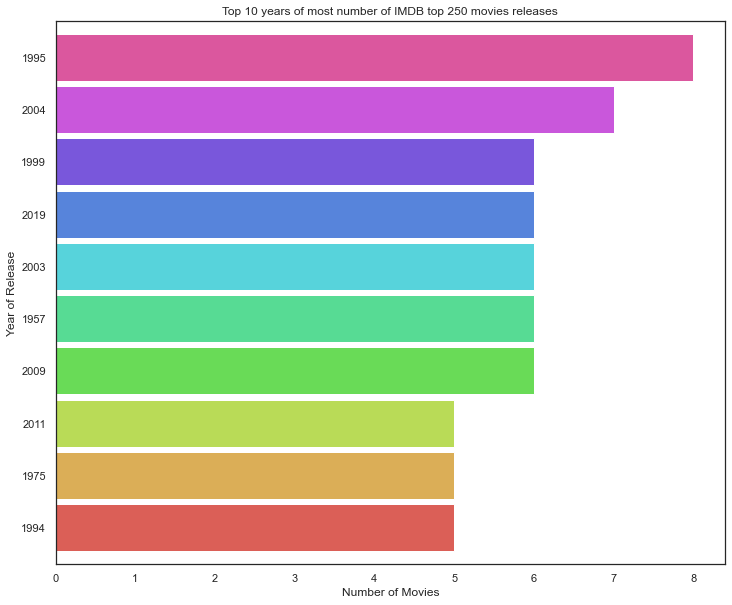

In [91]:
# Plotting years of release
plt.subplots(figsize=(12,10))
list_year = pd.Series(movies['Year'])

ax0 = list_year.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
plt.title('Top 10 years of most number of IMDB top 250 movies releases')
plt.xlabel("Number of Movies")
plt.ylabel("Year of Release")
plt.show()

According to the chart, 1995 and 2004 were "bumper years" for the film industry, with many popular films released in those years.

In [38]:
# Working with the Genres column 
movies1 = movies
movies1['Genres'] = movies1['Genres'].str.replace(' ','')
movies1['Genres'] = movies1['Genres'].str.split(',')
movies1['Genres']


0                             [Drama]
1                      [Crime, Drama]
2              [Action, Crime, Drama]
3                      [Crime, Drama]
4                      [Crime, Drama]
                    ...              
245     [Adventure, Biography, Drama]
246    [Animation, Adventure, Comedy]
247                           [Drama]
248                [Biography, Drama]
249    [Animation, Action, Adventure]
Name: Genres, Length: 250, dtype: object

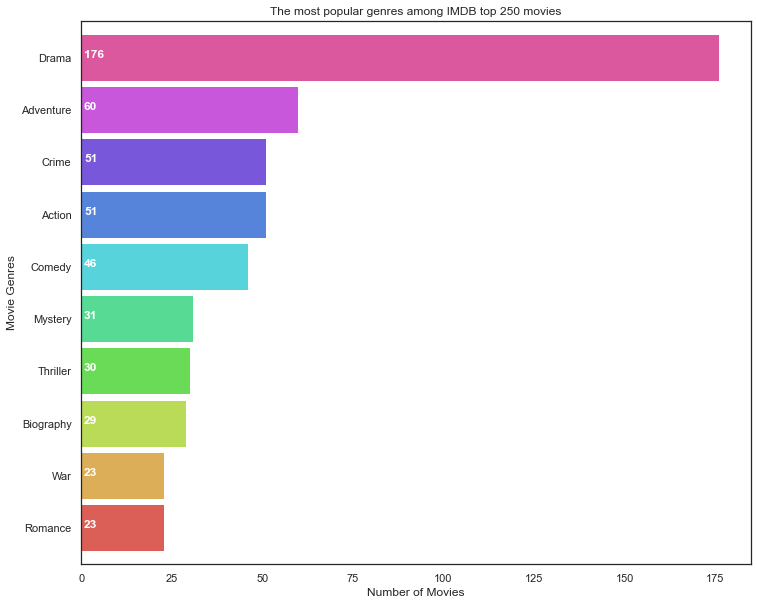

In [92]:
# Getting an insight of movie genres in terms of popularity
plt.subplots(figsize=(12,10))
list1 = []
for i in movies1['Genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('The most popular genres among IMDB top 250 movies')
plt.xlabel("Number of Movies")
plt.ylabel("Movie Genres")
plt.show()

As can be seen from the chart, the Drama genre has the highest number of films in the IMDB Top 250 (176), followed by the Adventure (60), Crime (51) and Action (51) genres.

In [12]:
# Data Correlation with numerical features
correlation = movies.corr()
correlation
logger.info(correlation)

                  Id      Year    Rating  Popularity  Metascore     Gross  \
Id          1.000000 -0.047725 -0.847917    0.184644  -0.196863 -0.203209   
Year       -0.047725  1.000000  0.025374   -0.259993   0.074436  0.413718   
Rating     -0.847917  0.025374  1.000000   -0.186696   0.076509  0.181992   
Popularity  0.184644 -0.259993 -0.186696    1.000000   0.017365 -0.287659   
Metascore  -0.196863  0.074436  0.076509    0.017365   1.000000  0.086107   
Gross      -0.203209  0.413718  0.181992   -0.287659   0.086107  1.000000   
Budget      0.072099  0.126963 -0.038265   -0.048481   0.015011  0.037683   

              Budget  
Id          0.072099  
Year        0.126963  
Rating     -0.038265  
Popularity -0.048481  
Metascore   0.015011  
Gross       0.037683  
Budget      1.000000  


Text(66.453125, 0.5, 'Movie Numerical Features')

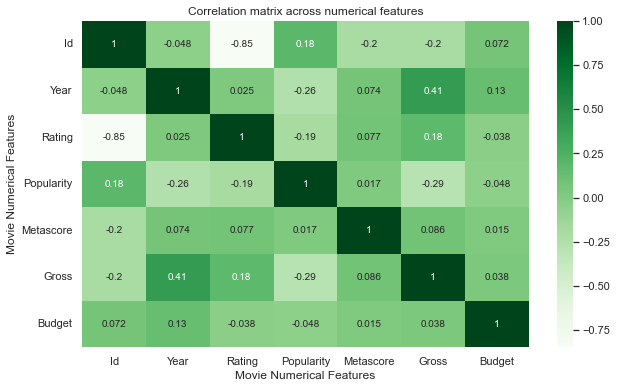

In [96]:
# Plotting the correlation across numerical features
plt.figure(figsize=(10,6))
sns.heatmap(correlation,annot=True,cmap="Greens")
plt.title("Correlation matrix across numerical features")
plt.xlabel("Movie Numerical Features")
plt.ylabel("Movie Numerical Features")

The heat map shows that the correlation between total movie gross and year is relatively high, indicating that the demand for movie entertainment increases with time. In addition, movie ratings are also correlated with grosses at the time of release, meaning that movies that do well at the box office generally have good word-of-mouth. It is surprising that the popularity of movies is negatively correlated with the year of release and box office grosses, implying that as box office grosses increase with the year of release, movies tend to be less popular with audiences. The reason for this problem may be related to the poor quality of movies in recent years

In [14]:
# Converting genres list to string that can be encoded later
movies2 = movies
movies2['Genres'] = [','.join(map(str, l)) for l in movies2['Genres']]
movies2['Genres']

0                           Drama
1                     Crime,Drama
2              Action,Crime,Drama
3                     Crime,Drama
4                     Crime,Drama
                  ...            
245     Adventure,Biography,Drama
246    Animation,Adventure,Comedy
247                         Drama
248               Biography,Drama
249    Animation,Action,Adventure
Name: Genres, Length: 250, dtype: object

In [102]:
# Encoding Categorical Data before correlation across all features
movies_converted = movies2[movies2.columns[:-1]]

for i in movies_converted.columns:
    if(movies_converted[i].dtype == "object"):
        movies_converted[i] = movies_converted[i].astype("category")
        movies_converted[i] = movies_converted[i].cat.codes

movies_converted
logger.debug(movies_converted)

      Id  Name  Year  Rating  Genres  Popularity  Metascore  Director  \
0      1   217  1994     9.3      71          82         81        44   
1      2   196  1972     9.2      63          97        100        42   
2      3   187  2008     9.0       9         136         84        20   
3      4   197  1974     9.0      63         548         90        42   
4      5     0  1957     9.0      63         340         96       134   
..   ...   ...   ...     ...     ...         ...        ...       ...   
245  246    43  1975     8.2      18           0          0         2   
246  247     8  1992     8.0      34        1444         86       127   
247  248   204  2011     8.1      71         798         62       142   
248  249    59  1982     8.1      44        3351         79       116   
249  250   207  1999     8.1      33        1922         85        12   

     Writers  Stars       Gross     Budget  
0        214    216    28884504   25000000  
1        147    158   250341816  

In [103]:
# New correlation with all features
correlation2 = movies_converted.corr()
logger.info(correlation2)

                  Id      Name      Year    Rating    Genres  Popularity  \
Id          1.000000 -0.060805 -0.047725 -0.847917  0.010807    0.184644   
Name       -0.060805  1.000000 -0.104380  0.085179 -0.041623   -0.077520   
Year       -0.047725 -0.104380  1.000000  0.025374 -0.187789   -0.259993   
Rating     -0.847917  0.085179  0.025374  1.000000 -0.029834   -0.186696   
Genres      0.010807 -0.041623 -0.187789 -0.029834  1.000000    0.171584   
Popularity  0.184644 -0.077520 -0.259993 -0.186696  0.171584    1.000000   
Metascore  -0.196863  0.001887  0.074436  0.076509  0.057988    0.017365   
Director    0.061738 -0.219874  0.116326 -0.020825  0.008031   -0.138709   
Writers     0.036737 -0.104146  0.106339  0.044349  0.032516   -0.170380   
Stars      -0.045458 -0.009037  0.030809  0.050474 -0.000119   -0.003759   
Gross      -0.203209  0.014939  0.413718  0.181992 -0.405091   -0.287659   
Budget      0.072099 -0.112105  0.126963 -0.038265  0.023350   -0.048481   

           

Text(84.453125, 0.5, 'Movie All Features')

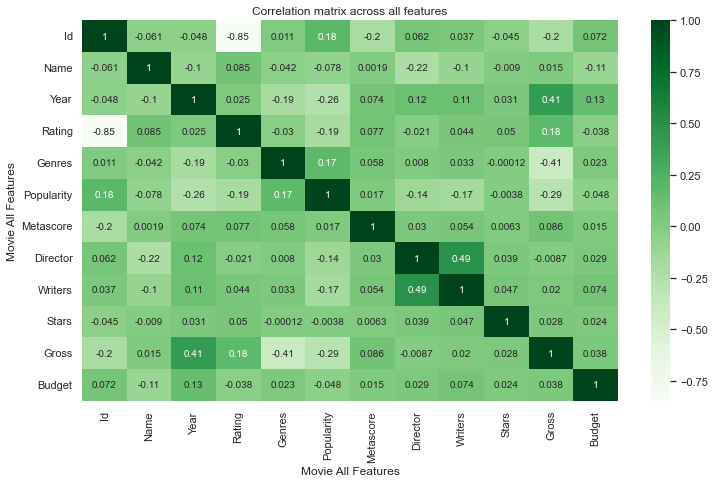

In [104]:
# Plotting the new correlation
plt.figure(figsize=(12,7))
sns.heatmap(correlation2,annot=True,cmap="Greens")
plt.title("Correlation matrix across all features")
plt.xlabel("Movie All Features")
plt.ylabel("Movie All Features")

The heat map correlating all features shows that the genre of the movie and the popularity of the movie are positively correlated, which means that the genre of the movie is also key in determining the popularity of the movie. Furthermore, movie genre and movie revenue are negatively correlated, suggesting that some movies with good word-of-mouth may not do as well at the box office as expected. Interestingly, movie directors and writers are positively correlated, referring to the fact that good movie directors tend to work with regular writers.

In [21]:
# Finding the correlation pairs
corpairs = movies_converted.corr()
corpairs = corpairs.unstack()
sorted_corpairs = corpairs.sort_values()
sorted_corpairs
logger.info(sorted_corpairs)

Rating      Id       -0.847917
Id          Rating   -0.847917
Genres      Gross    -0.405091
Gross       Genres   -0.405091
Popularity  Gross    -0.287659
                        ...   
Rating      Rating    1.000000
Year        Year      1.000000
Name        Name      1.000000
Gross       Gross     1.000000
Budget      Budget    1.000000
Length: 144, dtype: float64


In [28]:
# Finding the highest correlation
highestcor = sorted_corpairs[abs((sorted_corpairs))>=0.4]
highestcor

Rating      Id           -0.847917
Id          Rating       -0.847917
Genres      Gross        -0.405091
Gross       Genres       -0.405091
            Year          0.413718
Year        Gross         0.413718
Writers     Director      0.488656
Director    Writers       0.488656
Id          Id            1.000000
Stars       Stars         1.000000
Writers     Writers       1.000000
Director    Director      1.000000
Metascore   Metascore     1.000000
Popularity  Popularity    1.000000
Genres      Genres        1.000000
Rating      Rating        1.000000
Year        Year          1.000000
Name        Name          1.000000
Gross       Gross         1.000000
Budget      Budget        1.000000
dtype: float64